## Feature selection Using correlation matrix

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/processed/oversampled_heart_disease_dataset.csv")

In [3]:
df.shape

(6300, 16)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
corr_matrix = df.corr().abs()

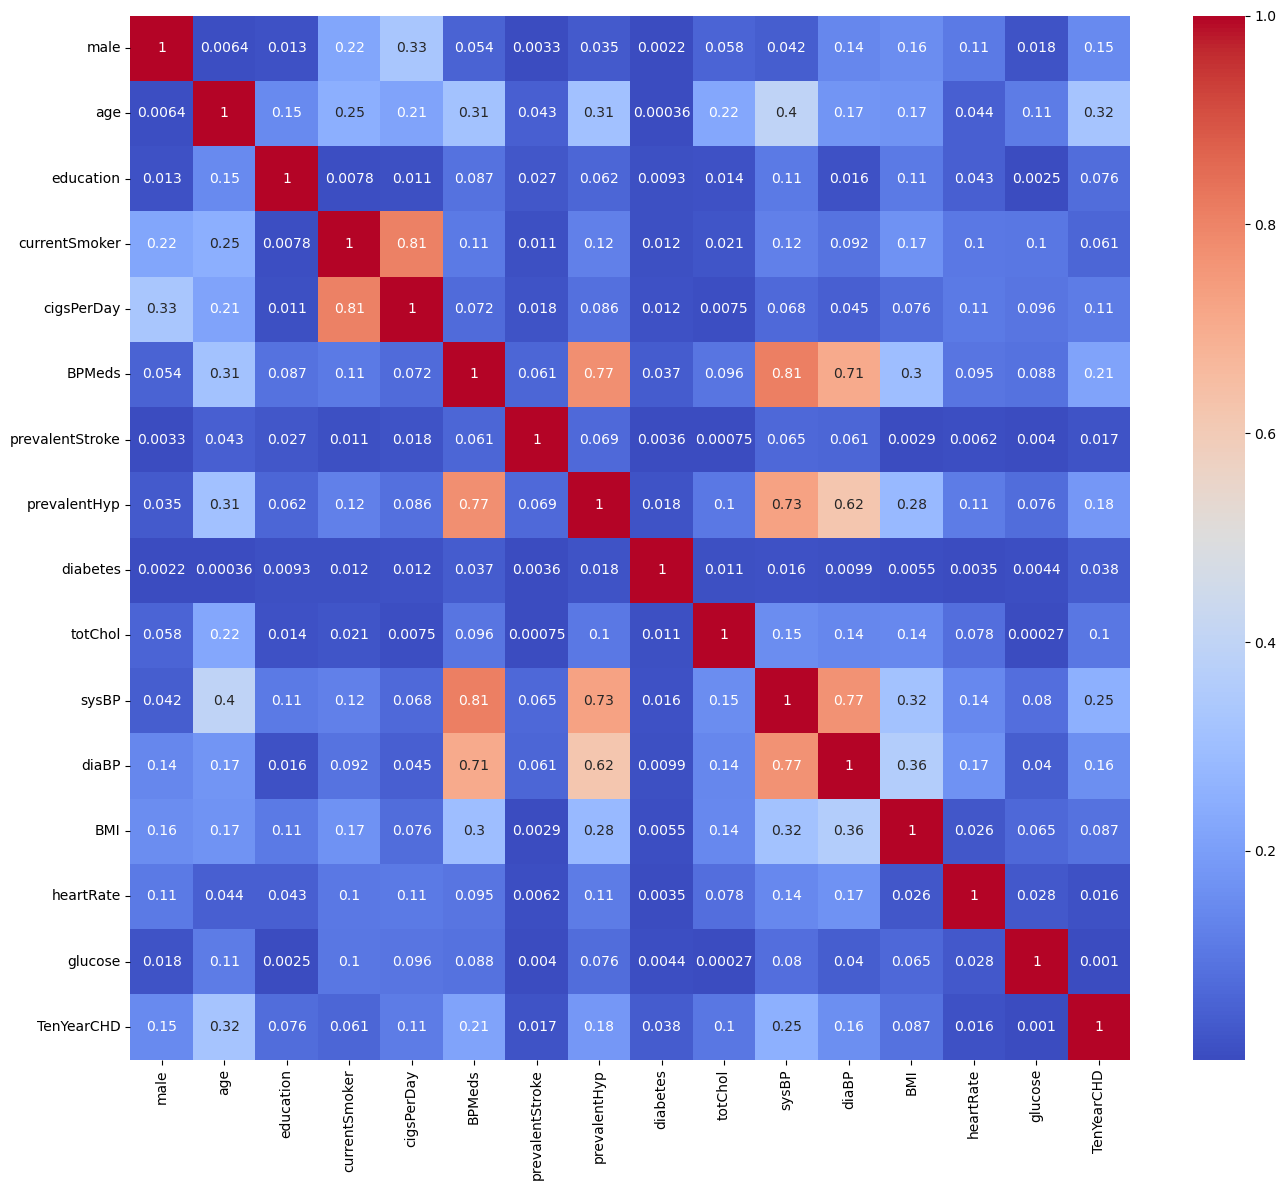

In [6]:
plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.tight_layout()

In [7]:
import numpy as np 

In [8]:
target_col = 'TenYearCHD'
target_corr = df.corr()[target_col].abs().sort_values(ascending=False)
to_drop = []
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
for col in upper.columns:
    high_corr_cols = [row for row in upper.index if abs(upper.loc[row, col]) > 0.7] # drop those with correlation > 0.8 
    for row in high_corr_cols:
        # Drop the one with smaller correlation to target
        if target_corr[row] < target_corr[col]:
            to_drop.append(row)
        else:
            to_drop.append(col)

In [9]:
to_drop

['currentSmoker', 'prevalentHyp', 'BPMeds', 'prevalentHyp', 'diaBP', 'diaBP']

In [10]:
df_selected = df.drop(columns=to_drop)

In [11]:
df_selected.shape

(6300, 12)

In [106]:
df_selected.columns

Index(['male', 'age', 'education', 'cigsPerDay', 'prevalentStroke', 'diabetes',
       'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

### Splitting the Dataset

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = df_selected.drop(columns=[target_col])
y = df_selected[target_col]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [15]:
X_train.shape

(5040, 11)

In [16]:
X_test.shape

(1260, 11)

In [17]:
import time

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
# Best parameters found - rf
best_params = {
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}

In [20]:
best_rf = RandomForestClassifier(**best_params, random_state=42)

In [21]:
start_time = time.time()

In [22]:
best_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=42)

In [23]:
end_time = time.time()

In [24]:
# Predictions
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

In [25]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, make_scorer
)

In [26]:
len(X_train.columns)

11

In [27]:
# Evaluation Metrics
metrics = {
    'Model': 'Random Forest',
    'Method used': 'Correlation Matrix',
    'No. of features': len(X_train.columns),
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_prob),
    'Training Time (s)': end_time - start_time
}

In [28]:
results_df = pd.DataFrame([metrics])

In [29]:
results_df.to_csv('../reports/results/selected_features_results.csv', index=False)
results_df

,Model,Method used,No. of features,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time (s)
0,Random Forest,Correlation Matrix,11,0.916667,0.888889,0.952381,0.91954,0.97339,4.997204


In [30]:
from xgboost import XGBClassifier

In [49]:
# Best parameters found - xgboost
best_params = {
    'objective': 'binary:logistic',
    'max_depth': 20,
    'learning_,rate': 0.05,
    'n_estimators': 500,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0
}


In [34]:
best_xgb = XGBClassifier(**best_params,
    random_state=42,
    eval_metric='auc'
)

In [35]:
start_time = time.time()

In [36]:
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [37]:
end_time = time.time()

In [38]:
# Predictions
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

In [44]:
# Evaluation Metrics
metrics = {
    'Model': 'XGBoost',
    'Method used': 'Correlation Matrix',
    'No. of features': len(X_train.columns),
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_prob),
    'Training Time (s)': end_time - start_time
}

In [45]:
old_results = pd.read_csv('../reports/results/selected_features_results.csv')
results_df = pd.concat([old_results, pd.DataFrame([metrics])], ignore_index=True)

In [47]:
results_df.to_csv('../reports/results/selected_features_results.csv', index=False)
results_df

,Model,Method used,No. of features,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time (s)
0,Random Forest,Correlation Matrix,11,0.916667,0.888889,0.952381,0.91954,0.97339,4.997204
1,XGBoost,Correlation Matrix,11,0.933333,0.940323,0.925397,0.93280,0.97741,6.310040


## Dimensionality Reduction (PCA)
### Feature Scaling (Normalization)

In [50]:
numerical_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

In [51]:
df = pd.read_csv("../data/processed/heart_disease_dataset.csv")

In [52]:
df.shape

(3632, 16)

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in numerical_columns:
    df[col] = scaler.fit_transform(df[[col]])

In [54]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,-1.181892,4.0,0,-0.784892,0.0,0,0,0,-0.970372,-1.276802,-1.111981,0.459238,0.495604,-0.129218,0
1,0,-0.355887,2.0,0,-0.784892,0.0,0,0,0,0.399597,-0.438101,-0.042058,0.968313,1.883510,-0.230446,0
2,1,-0.119885,1.0,1,0.926014,0.0,0,0,0,0.275054,-0.074664,-0.139324,-0.012235,0.032968,-0.837814,0
3,0,1.414125,3.0,1,1.781466,1.0,0,1,0,-0.223116,1.183387,1.319661,0.924926,-0.892302,2.502708,1
4,0,-0.355887,3.0,1,1.182649,0.0,0,0,0,1.271394,0.065119,0.249739,-0.660149,0.958239,0.680605,0


### Data Oversampling

In [55]:
target_col = 'TenYearCHD'

X = df.drop(columns=[target_col])
y = df[target_col]

In [56]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [57]:
X.shape

(6300, 15)

Class Counts:
TenYearCHD
0    3150
1    3150
Name: count, dtype: int64
Imbalance Ratio: 1.0


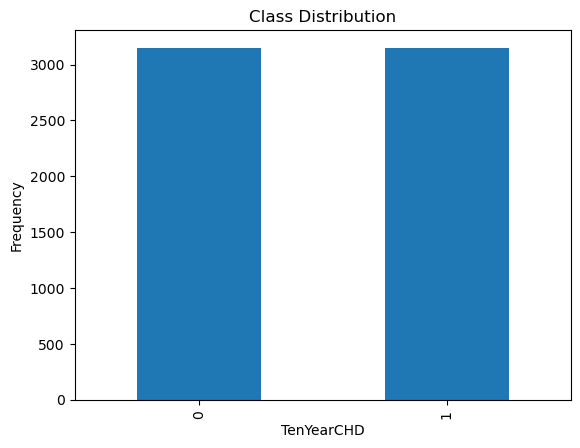

In [58]:
class_counts = y.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Class Counts:\n{class_counts}")
print(f"Imbalance Ratio: {imbalance_ratio}")
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("TenYearCHD")
plt.ylabel("Frequency")
plt.show()

In [59]:
from sklearn.decomposition import PCA

In [60]:
pca = PCA()
pca.fit(X)

PCA()

Text(0.5, 1.0, 'PCA Explained Variance')

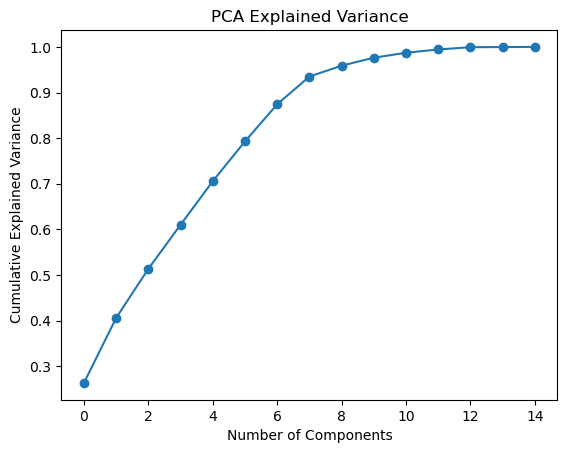

In [61]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')


In [62]:
pca = PCA(n_components=8)
X_reduced = pca.fit_transform(X)

In [63]:
X_reduced.shape

(6300, 8)

### Splitting the Dataset

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)

In [65]:
X_train.shape

(5040, 8)

In [66]:
X_test.shape

(1260, 8)

In [69]:
# Best parameters found - rf
best_params = {
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}

In [70]:
best_rf = RandomForestClassifier(**best_params, random_state=42)

In [71]:
start_time = time.time()

In [72]:
best_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=42)

In [73]:
end_time = time.time()

In [74]:
# Predictions
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

In [75]:
# Evaluation Metrics
metrics = {
    'Model': 'Random Forest',
    'Method used': 'PCA',
    'No. of features': '8',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_prob),
    'Training Time (s)': end_time - start_time
}

In [76]:
old_results = pd.read_csv('../reports/results/selected_features_results.csv')
results_df = pd.concat([old_results, pd.DataFrame([metrics])], ignore_index=True)

In [78]:
results_df.to_csv('../reports/results/selected_features_results.csv', index=False)
results_df

,Model,Method used,No. of features,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time (s)
0,Random Forest,Correlation Matrix,11,0.916667,0.888889,0.952381,0.919540,0.973390,4.997204
1,XGBoost,Correlation Matrix,11,0.933333,0.940323,0.925397,0.932800,0.977410,6.310040
2,Random Forest,PCA,8,0.893651,0.869048,0.926984,0.897081,0.962281,7.323970


In [83]:
# Best parameters found - xgboost
best_params = {
    'objective': 'binary:logistic',
    'max_depth': 20,
    'learning_rate': 0.05,
    'n_estimators': 500,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0
}


In [84]:
best_xgb = XGBClassifier(**best_params,
    random_state=42,
    eval_metric='auc'
)

In [85]:
start_time = time.time()

In [86]:
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [87]:
end_time = time.time()

In [88]:
# Predictions
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

In [90]:
# Evaluation Metrics
metrics = {
    'Model': 'XGBoost',
    'Method used': 'PCA',
    'No. of features': '8',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_prob),
    'Training Time (s)': end_time - start_time
}

In [91]:
old_results = pd.read_csv('../reports/results/selected_features_results.csv')
results_df = pd.concat([old_results, pd.DataFrame([metrics])], ignore_index=True)

In [93]:
results_df.to_csv('../reports/results/selected_features_results.csv', index=False)
results_df

,Model,Method used,No. of features,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time (s)
0,Random Forest,Correlation Matrix,11,0.916667,0.888889,0.952381,0.919540,0.973390,4.997204
1,XGBoost,Correlation Matrix,11,0.933333,0.940323,0.925397,0.932800,0.977410,6.310040
2,Random Forest,PCA,8,0.893651,0.869048,0.926984,0.897081,0.962281,7.323970
3,XGBoost,PCA,8,0.895238,0.872754,0.925397,0.898305,0.961963,5.690819
